## Deriving the Allan deviation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.fftpack import fft, fftfreq
import numpy as np
import allantools
import os

figure_path = os.path.join(os.getcwd(), "figures")
data_path = os.path.join(os.getcwd(), "laser_gyroscope_data", "allan")

In [3]:
# import data

# get only frequency and time 
data = np.genfromtxt(os.path.join(data_path, "defbuffer1_0405_161532_final.csv"), delimiter=",", skip_header=9, usecols=(0, 13))
# print(type(data[:,0]))

Text(0.5, 1.0, 'Raw data')

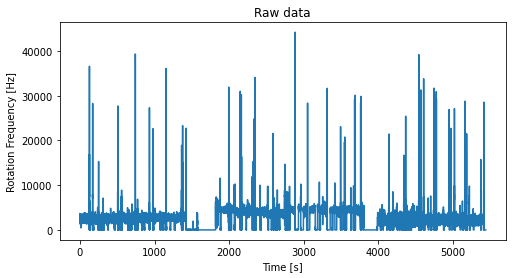

In [4]:
# plot the time series to check
freq = data[:,0]
time = data[:,1]

plt.figure(figsize=(8,4))
plt.plot(time, freq)
plt.xlabel("Time [s]")
plt.ylabel("Rotation Frequency [Hz]")
plt.title("Raw data")

Average frequency: 2430.77924970679 Hz
Average frequency: 4221.718415875792 Hz
Average frequency: 1967.5223259579775 Hz


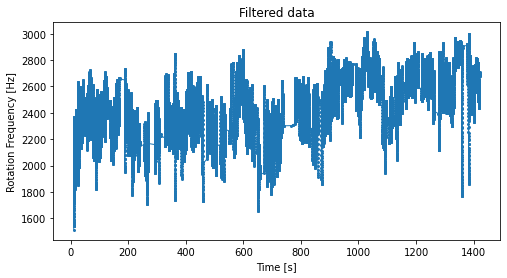

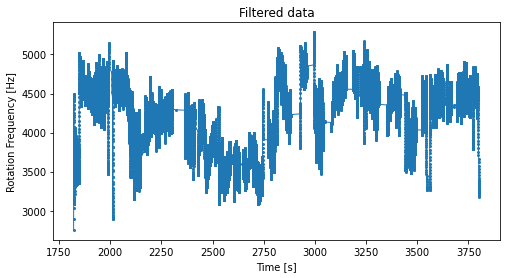

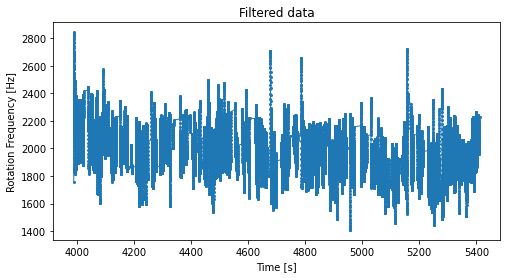

In [5]:
# remove places where the laser locked
# this is where the frequency reached zero or when it spiked, which is around freq > 4000 Hz
# or any perturbation around zero, so that we remove any frequency below 700 Hz

# from scipy.ndimage import uniform_filter1d
from scipy.signal import lfilter, ellip, sosfilt

# n = 15  # the larger n is, the smoother curve will be
# b = [1.0 / n] * n
# a = 1
# yy = lfilter(b,a,y)

cut_vals = [(900, 3000), (2800,5600)]


# data_filt = data[(freq < 6000) & (freq > 900)]
# find indices where t ~ 1500 and t ~ 3800 
tbeg_idces = np.argwhere((time <=1500) & (time >=10))
tmid_idces = np.argwhere((time >=1800) & (time <=3850))
tend_idces = np.argwhere(time >=3950)

# print(tbeg_idces, tend_idces)

time_beg = time[tbeg_idces]
time_mid = time[tmid_idces]
time_end = time[tend_idces]
tme_list = [time_beg, time_mid, time_end]

freq_beg = freq[tbeg_idces]
freq_mid = freq[tmid_idces]
freq_end = freq[tend_idces]

sos = ellip(20, 0.009, 80, 0.05, output='sos')
# freq_filt = sosfilt(sos, data_filt[:,0])

freq_filts = []
time_filts = []


for i, frqs in enumerate([freq_beg, freq_mid, freq_end]):
    
    freq_cut = frqs[(frqs < cut_vals[i%2][1]) & (frqs > cut_vals[i%2][0])]
    time_cut = tme_list[i][(frqs < cut_vals[i%2][1]) & (frqs > cut_vals[i%2][0])]

    # freq_cut = data_cut[:,0]
    # time_cut = data_cut[:,1]

    freq_filt = sosfilt(sos, freq_cut)
    freq_filts.append(freq_filt[50:])
    time_filts.append(time_cut[50:])
# n = 15
# b = (1.0 / n) * n * np.ones_like(data_filt[:,0])
# a = np.ones_like(data_filt[:,0])
# freq_filt = lfilter(b,a,data_filt[:,0])



# freq_filt = uniform_filter1d(data_filt[:,0], size=5)
# t_filt = data_filt[:,1]

for i in range(3):
    plt.figure(figsize=(8,4))
    plt.plot(time_filts[i], freq_filts[i], marker="o",ls="-", ms=2.0, lw=1.0)
    plt.xlabel("Time [s]")
    plt.ylabel("Rotation Frequency [Hz]")
    plt.title("Filtered data")

    # print average frequency
    print("Average frequency: {0} Hz".format(np.mean(freq_filts[i])))


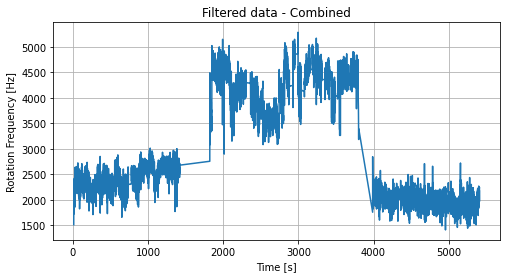

In [6]:
dt = time[1] - time[0]
time_filted = np.hstack(tuple(time_filts))
freq_filted = np.hstack(tuple(freq_filts))


time_filted_v1 = np.linspace(0., dt * len(time_filted), len(time_filted))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(time_filted, freq_filted)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Rotation Frequency [Hz]")
ax.set_title("Filtered data - Combined")
ax.grid()

No handles with labels found to put in legend.


sample rate: 55.50621669626998 Hz


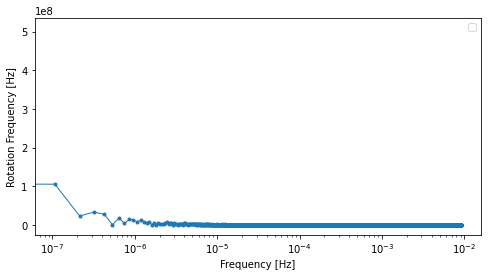

In [7]:
# perform fft on the filtered data
# determine allan deviation
# combine the frequency measurement after filtering
from scipy.fft import fft, fftfreq

# sampling rate
dt = time[1] - time[0]
dfreq = 1 / dt
print("sample rate: {0} Hz".format(dfreq))


N = len(freq_filted)

y_fft = np.abs(fft(freq_filted))[:N//2]
freq_fft = fftfreq(N, dfreq)[:N//2]

fig, ax = plt.subplots(figsize=(8,4))
ax.semilogx(freq_fft, y_fft, marker="o", ls="-", lw=1.0, ms=3.0)

ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Rotation Frequency [Hz]")
ax.legend()


slope (should be ~ -1/2): -0.42732626886117414 +- 4.773409863064516e-07, intercept: 12.550847076801169 +- 3.225966718363144e-06, A: 282334.2909630637 +- 0.9108010260994998
Shot-noise limitation: 30.0 s


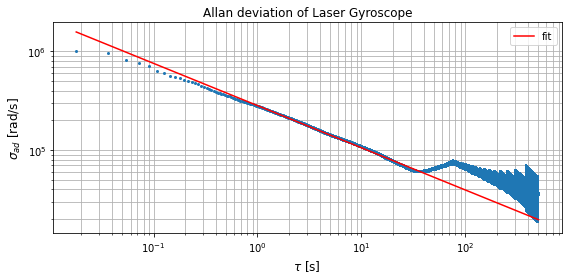

In [17]:


# get allan deviation
(t2, ad, ade, adn) = allantools.adev(y_fft, rate=dfreq, data_type="freq", taus=time_filted_v1)

# ad_cutoff = ad[(t2 > 4e-1) & (t2 < 1.2)]
# t2_cutoff = t2[(t2 > 4e-1) & (t2 < 1.2)]
ad_cutoff = ad[t2 < 3e1]
t2_cutoff = t2[t2 < 3e1]

# aderr_cutoff = ade[(t2 > 4e-1) & (t2 < 1.5)] / np.sqrt(adn)

# take log on both sidfes
log_allandev = np.log(ad_cutoff)
log_tau = np.log(t2_cutoff)

# perform fit for log (allan_dev) = -1/2 log(tau) + log (A)
(slope, logA), cov = np.polyfit(log_tau, log_allandev, 1, cov=True)

# variance is the diagonal elements of the covariance matrix
slope_err = cov[0,0]
logA_err = cov[1,1]
A_err = np.exp(logA) * logA_err

print("slope (should be ~ -1/2): {0} +- {3}, intercept: {1} +- {4}, A: {2} +- {5}".format(slope, logA, np.exp(logA), slope_err, logA_err, A_err))
ad_thr = np.exp(logA) * t2**slope

fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
ax.errorbar(t2, ad, yerr=ade / np.sqrt(adn), marker="o", ls="", ms=2.0)   # the data
ax.plot(t2, ad_thr, color="r", zorder=3, label = 'fit')

ax.set_xlabel(r"$\tau$ [s]", fontsize=12)
ax.set_ylabel(r"$\sigma_{{ad}}$ [rad/s]", fontsize=12)
ax.set_title("Allan deviation of Laser Gyroscope", fontsize=12)

ax.set_xscale("log")
ax.set_yscale("log")

ax.legend()
ax.grid(which='both')

# shot-noise
tau_shotnoise = 3e1
print("Shot-noise limitation: {0} s".format(tau_shotnoise))

In [18]:
# compare with theoretic values
F = 1  # the finesse of the ring, determined from ring-down

c = 3e8  # m/s
wvlgth = 1064e-9   # laser wavelength
Popt = 1e-6  # optical power in W = J/s
h =  6.62607015e-34   # in J*s

# obtained from cavity resonance analysis
P = 0.9981852868527146
P_err = 0.00039225021807075885

# P = 4L
L = 0.25 * P
L_err = 0.25 * P_err

# A = L^2
A = L**2.
A_err = 2 * L * L_err

print("Area: {0} +- {1} m".format(A, A_err))

# analytical gyroscope sensitivity
delta_Omega = 0.25 * np.sqrt(c**3. * h * wvlgth / (Popt * tau_shotnoise)) / (A * F)

print("Theoretical gyroscope sensitivity: {0} m rad /s".format(delta_Omega * 1e3))


Area: 0.06227336668057726 +- 4.894229955537503e-05 m
Theoretical gyroscope sensitivity: 0.10112481648715795 m rad /s


In [9]:

# # determine allan deviation

# # sampling rate
# dt = time[1] - time[0]
# dfreq = 1 / dt
# print("sample rate: {0} Hz".format(dfreq))

# # cutoff_ranges = [(3e-1, 1.5e0), (3e-1, 1.5e0), (3e-1, 1e1)]
# cutoffs = [1e1, 1.5e1, 1e1]

# for i in range(3):
#     # get allan deviation
#     y_fft = np.abs(fft(freq_filts[i]))[:N//2]
#     (t2, ad, ade, adn) = allantools.adev(y_fft, rate=dfreq, data_type="freq", taus=time_filts[i] - time_filts[i][0])

#     # ad_cutoff = ad[(t2 > cutoff_ranges[i][0]) & (t2 < cutoff_ranges[i][1])]
#     # t2_cutoff = t2[(t2 > cutoff_ranges[i][0]) & (t2 < cutoff_ranges[i][1])]
#     ad_cutoff = ad[t2 > cutoffs[i]]
#     t2_cutoff= t2[t2 > cutoffs[i]]

#     # take log on both sidfes
#     log_allandev = np.log(ad_cutoff)
#     log_tau = np.log(t2_cutoff)

#     # perform fit for log (allan_dev) = -1/2 log(tau) + log (A)
#     (slope, logA), cov = np.polyfit(log_tau, log_allandev, 1, cov=True)

#     # variance is the diagonal elements of the covariance matrix
#     slope_err = cov[0,0]
#     logA_err = cov[1,1]
#     A_err = np.exp(logA) * logA_err

#     print("slope (should be ~ -1/2): {0} +- {3}, intercept: {1} +- {4}, A: {2} +- {5}".format(slope, logA, np.exp(logA), slope_err, logA_err, logA_err))
#     ad_thr = np.exp(logA) * t2**slope

#     fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
#     ax.errorbar(t2, ad, yerr=ade/np.sqrt(adn), marker="o", ls="", ms=2.0)   # the data
#     ax.plot(t2, ad_thr, color="r", zorder=3, label = 'fit')

#     ax.set_xlabel(r"$\tau$ [s]", fontsize=12)
#     ax.set_ylabel(r"$\sigma_{{ad}}$ [rad/s]", fontsize=12)
#     ax.set_title("Allan deviation of Laser Gyroscope", fontsize=12)
#     ax.set_xscale("log")
#     ax.set_yscale("log")

#     ax.legend()
#     ax.grid(which='both')